
[![Video Title](https://img.youtube.com/vi/1pedAIvTWXk/0.jpg)](https://www.youtube.com/watch?v=1pedAIvTWXk)

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [8]:
!pip install datasets evaluate transformers[sentencepiece] -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
^C


# Behind the pipeline (PyTorch)

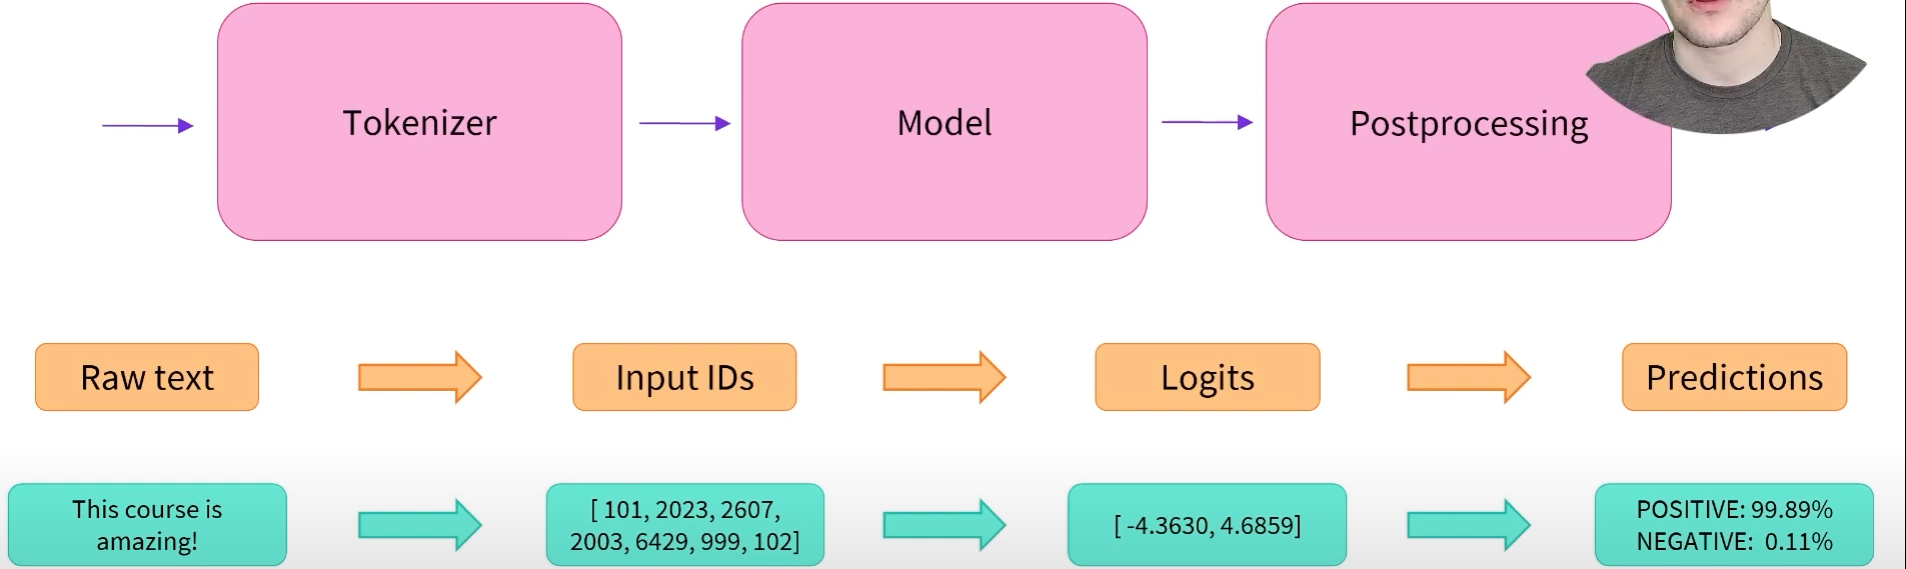

> # Stage 1: Tokenization
> ---
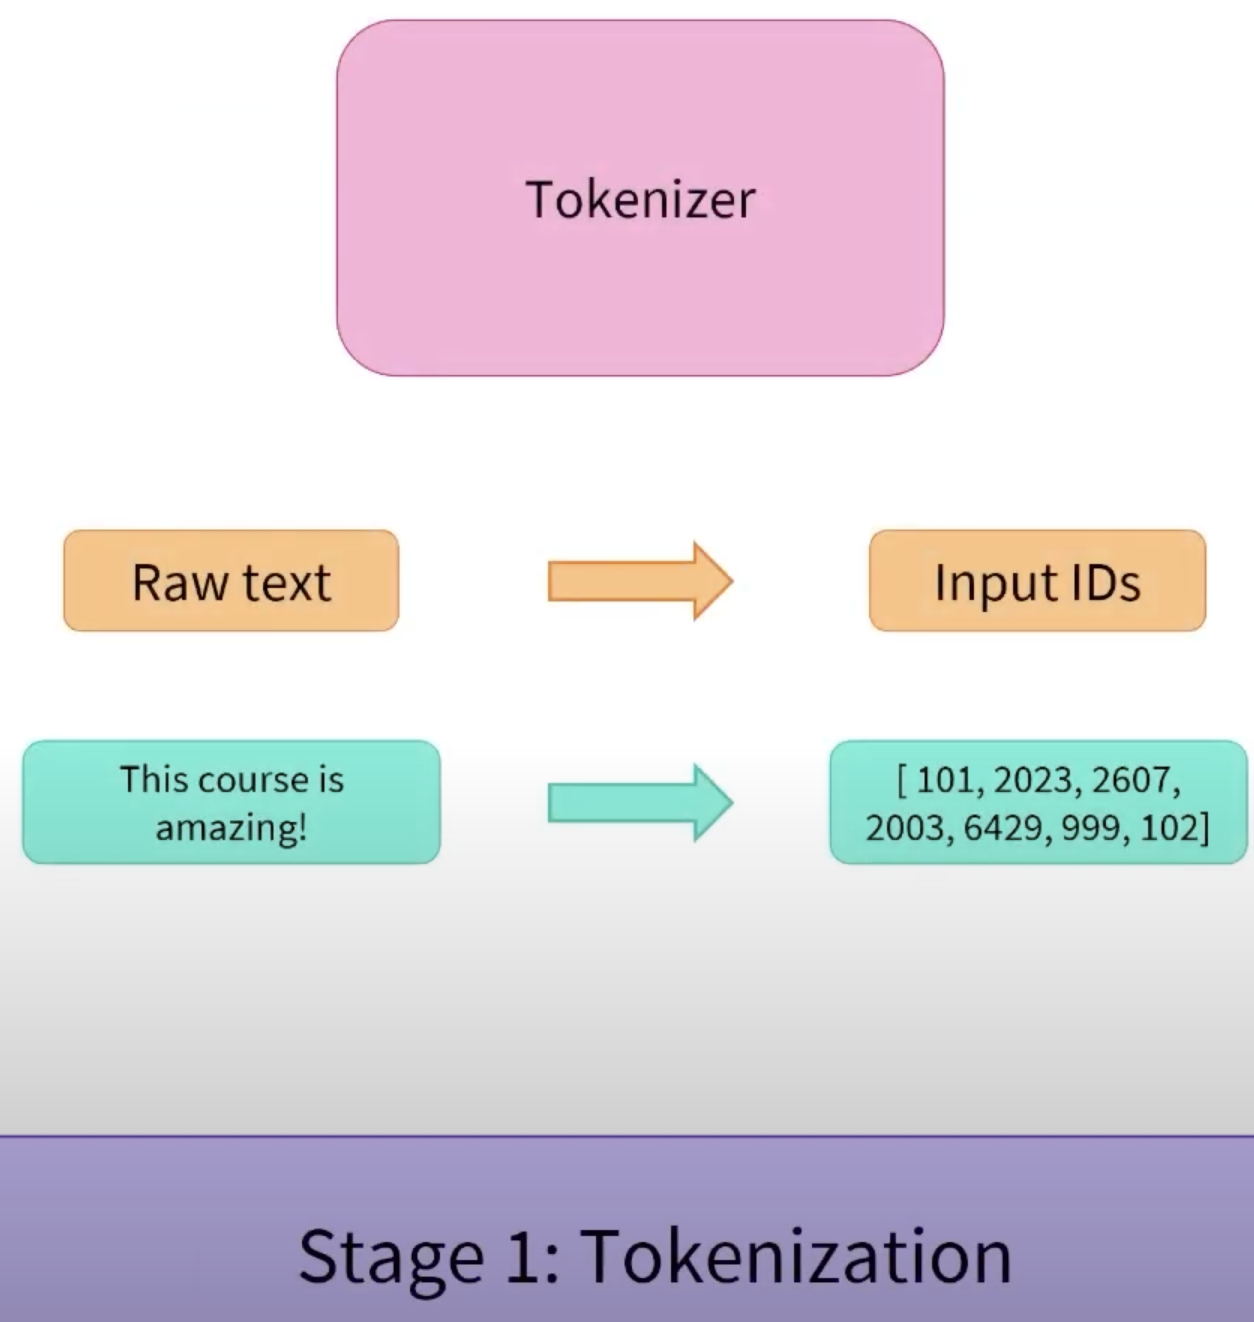

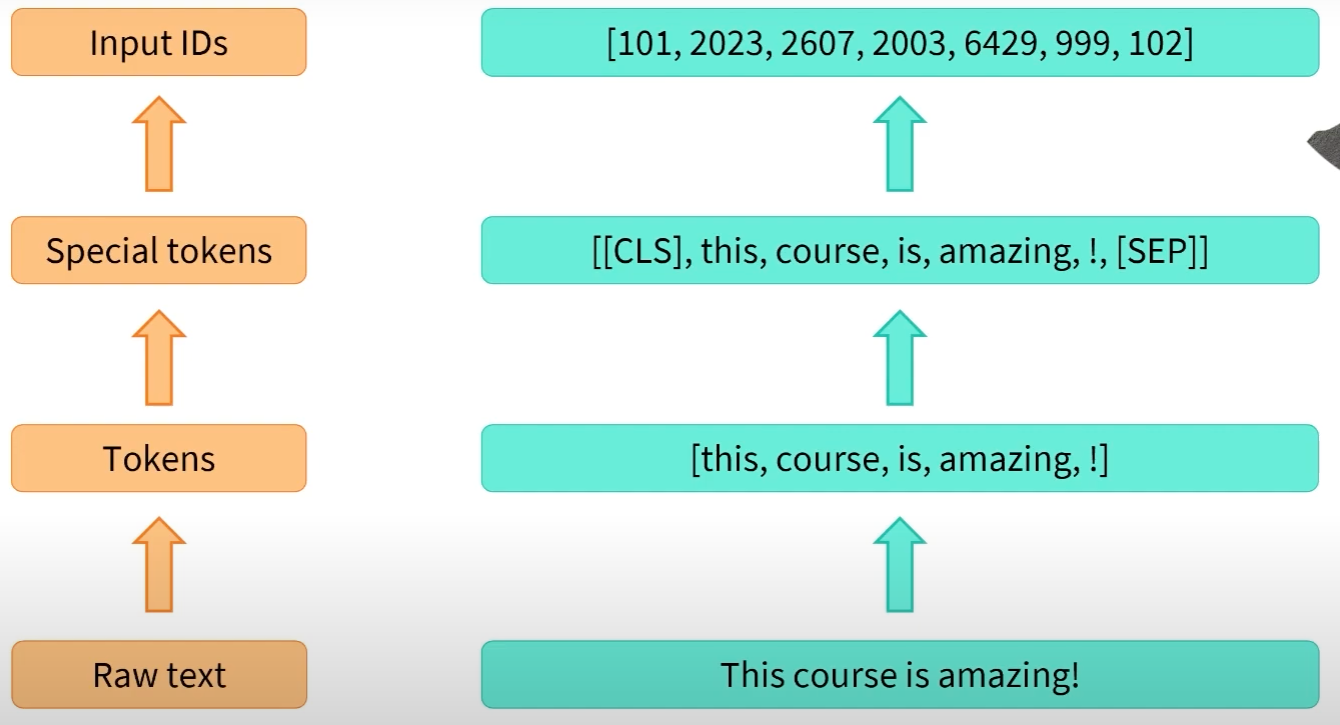
 

* notice how padding happens since sentences in batch are not same size!

In [4]:
import torch
from transformers import AutoTokenizer
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
# most important method of class is `.from_pretrained`
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# download & cache config & vocab associated with checkpoint
# checkpoint used by default is sentiment analysis checkpoint
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True,
                   truncation=True, return_tensors="pt")

# padding=True --> will pad shorter sentence in batch
# truncation=True --> any sentence longer than what the model can handle is truncated
# return_tensor --> pt option selected ; PyTorch, TensorFlow, or plain NumPy
#   * if return_tensor not specified get list of lists
{
    'input_ids': torch.tensor([
        [101, 1045, 1005, 2310, 2042, 3403, 2005, 1037,
            17662, 12172, 2607, 2026, 2878, 2166, 1012, 102],
        [101, 1045, 5223, 2023, 2061, 2172, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0]
    ]),
    'attention_mask': torch.tensor([
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ])
}

/home/vscode/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
           2607,  2026,  2878,  2166,  1012,   102],
         [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
              0,     0,     0,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [7]:
inputs

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}

### `inputs` keys
* `input_ids` vocab dictionary lookups of `raw_inputs` 
* `attention_mask` indicates where padding has been applied with 0s
  
> # Stage 2: Model
> ---
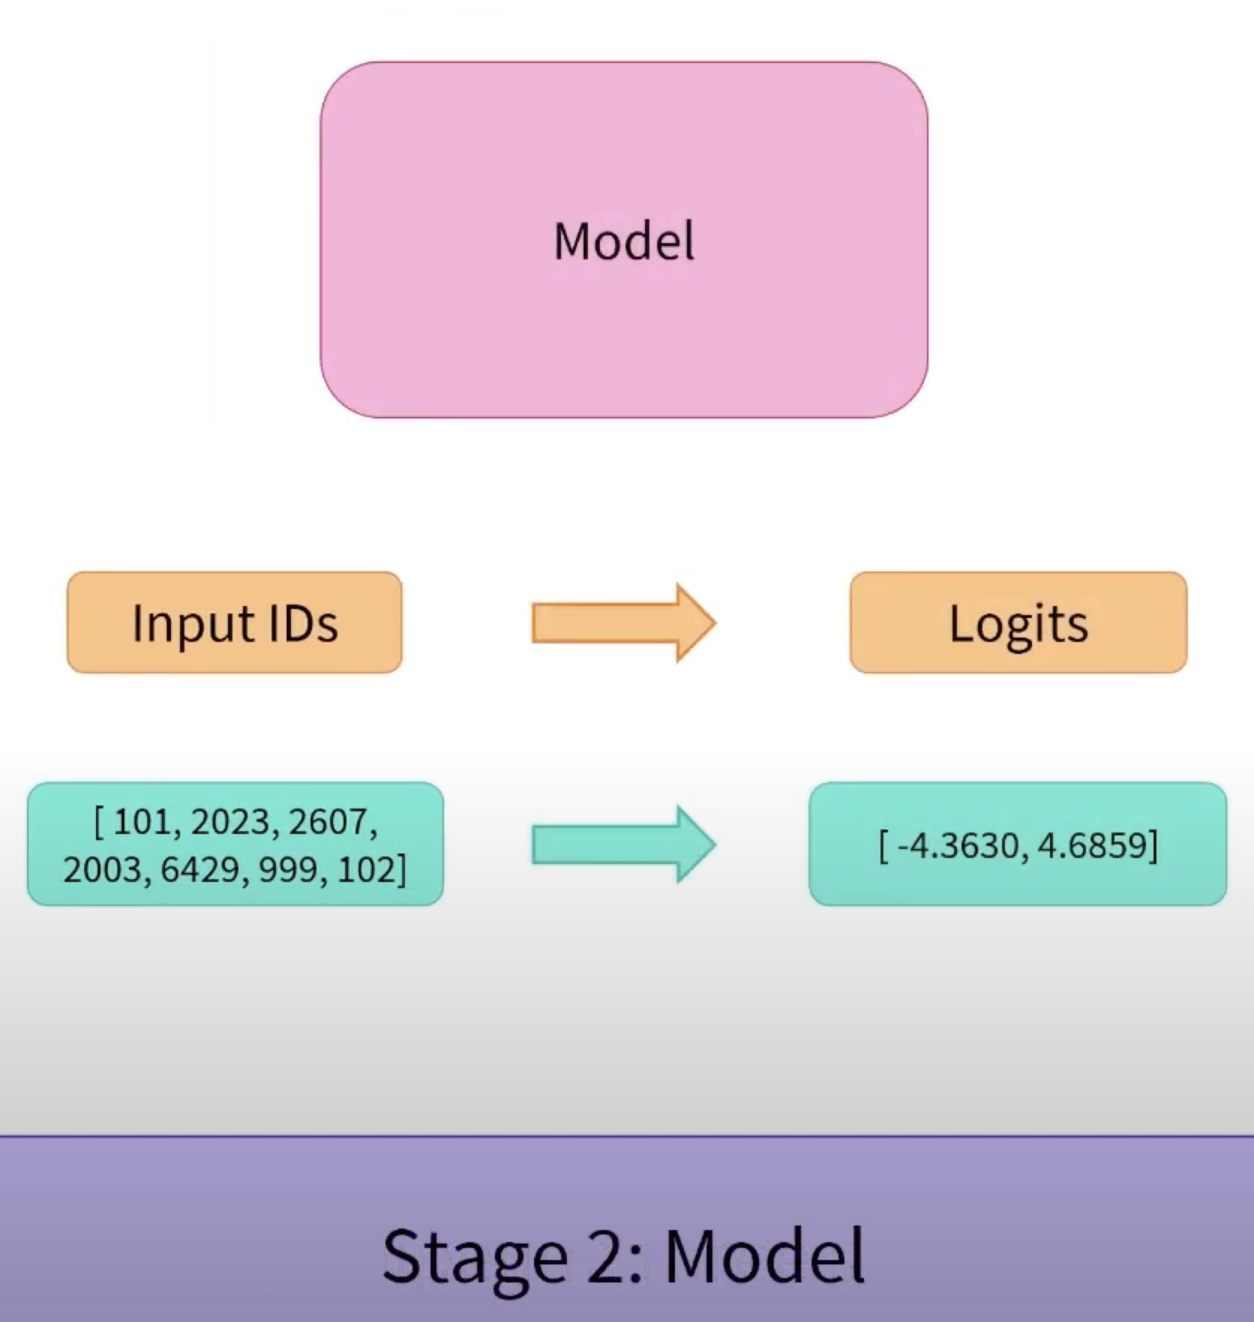

API used will determine what portion of of model is instantiated
> ### `AutoModel` outputs model body only → without classification head

In [ ]:
from transformers import AutoModel
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)
# download & cache config of model & pretrained weights
# AutoModel API only instatiates body of model
# --> part of model that is left once pre-training head is removed
# --> Output will be high-dimensional representation of sentences passed that is not directly usable for downstream tasks
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

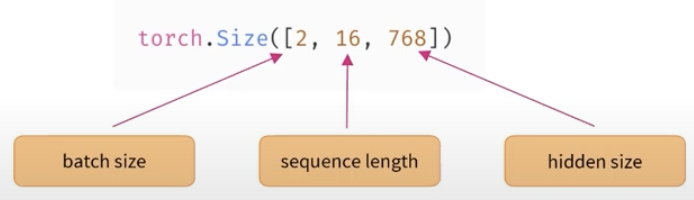

> ### `AutoModelForSequenceClassification` outputs model with classification head

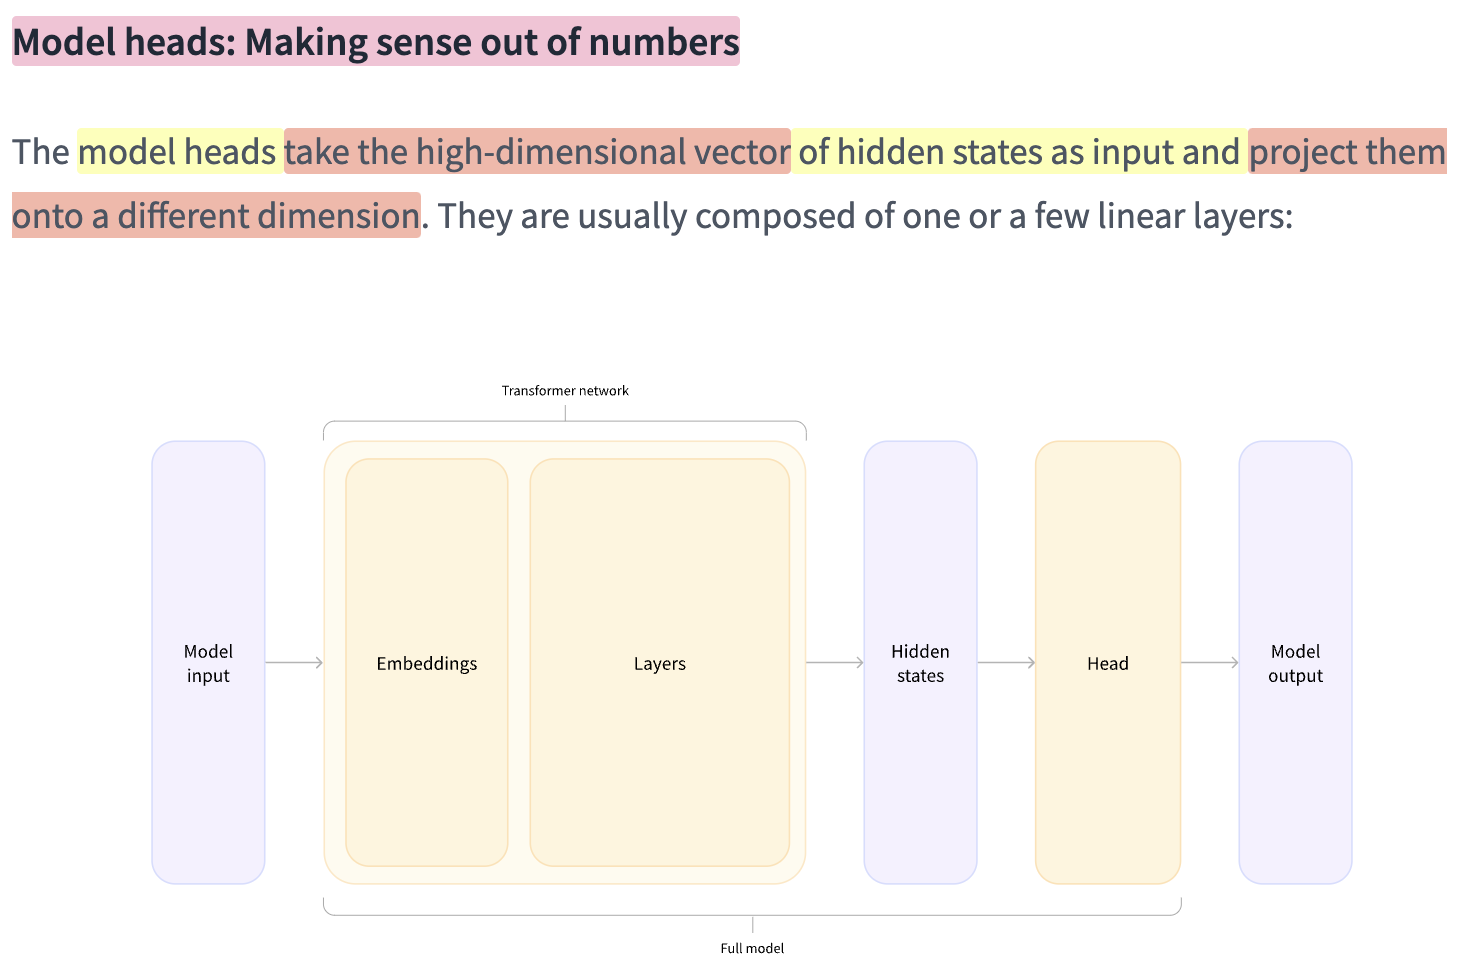

* There is an `AutoClass` for each common NLP task

* outputs are not Probabilities yet, don't sum to 1
  * model outputs Logits! 

In [10]:
from transformers import AutoModelForSequenceClassification
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)


> # Stage 3: Postprocessing
> ---
* To convert Logits into Probabilities a SoftMax layers must be applied
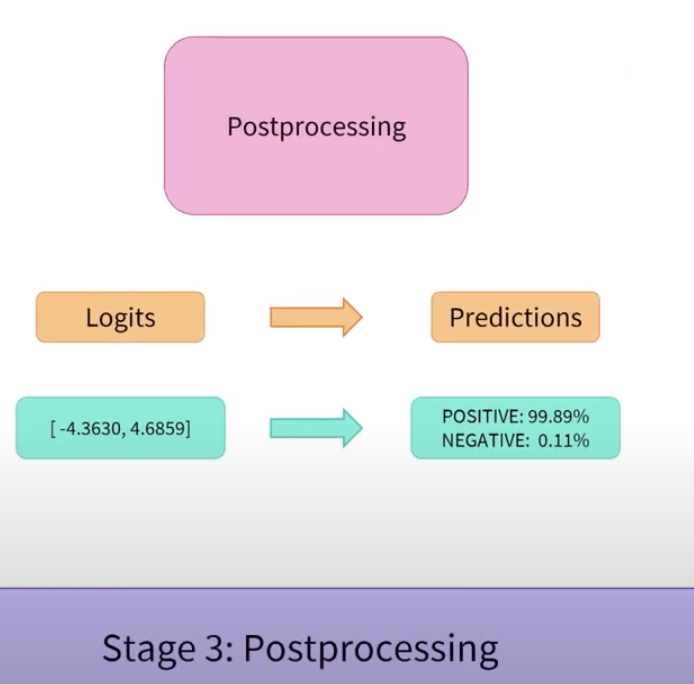

In [11]:
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5981e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


### Last step is to know which positions correspond to which labels

In [12]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

---

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

[{'label': 'POSITIVE', 'score': 0.9598047137260437},
 {'label': 'NEGATIVE', 'score': 0.9994558095932007}]

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True,
                   truncation=True, return_tensors="pt")
print(inputs)

{
    'input_ids': tensor([
        [  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172, 2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,     0,     0,     0,     0,     0,     0]
    ]), 
    'attention_mask': tensor([
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    ])
}

In [ ]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

In [ ]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])

In [ ]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

In [ ]:
print(outputs.logits.shape)

torch.Size([2, 2])

In [ ]:
print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward>)

In [ ]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward>)

In [ ]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}